In [2]:
%matplotlib notebook
import numpy as np
from IPython.display import display, clear_output
from ipywidgets import interact, interact_manual, FloatSlider
#from numba import jit
import matplotlib.pyplot as plt
from PIL import Image
import time
import warnings
from time import sleep
warnings.filterwarnings('ignore')

In [3]:
lena_rgb = np.array(Image.open('resources/Lena.png'), dtype=np.uint8)

## Histogram 

### calculate the gray, r, g, and b histograms for the lena_rgb image
For this exercices you're supposed to create four histograms. The first histogram is the grayscale histogram and the remaining are the color channels R, G, B. Use the weighted sum of the three linear-intensity values formular $Y' = 0.2126 \times R + 0.7152 \times G + 0.0722 \times B$  to grayscale the RGB image. 

The result should look like this:
![](resources/histogram_gt.png)


**Hint**: 
* Write a function to generate the histogram, you need it the next tasks.
* You just need a single numpy array with the shape `(4, 256)` to save the histogram bins for gray, r, g, and b.
* you can have multiple plots in matplotlib using plt.subplot()
* use `plt.bar` for your histogram with `plt.xlim([0,255])` to limit the x axis interval

#### Solution 1

In [5]:
lena_rgb.shape[0:2]

(512, 512)

In [6]:
def loop_hist(lena_rgb):
    hist = np.zeros((4,256), dtype=np.uint64)
    gray = np.zeros((lena_rgb.shape[0:2]))
    for y in range(lena_rgb.shape[0]):
        for x in range(lena_rgb.shape[1]):
            r, g, b = int(lena_rgb[y,x,0]), int(lena_rgb[y,x,1]), int(lena_rgb[y,x,2])
            Y = int(r * 0.2126 + g * 0.7152 + b * 0.0722)
            gray[y,x] = Y
            hist[0, Y] += 1
            hist[1, r] += 1
            hist[2, g] += 1
            hist[3, b] += 1
            
    return hist, gray

In [7]:
hist, gray = loop_hist(lena_rgb)

KeyboardInterrupt: 

In [8]:
%timeit loop_hist(lena_rgb)

6.74 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Solution 2

In [4]:
def numpy_hist(lena_rgb):
    r_channel, g_channel, b_channel = [lena_rgb[:,:,i].flatten() for i in [0, 1, 2]]

    numpy_gray = (lena_rgb * [0.2126, 0.7152, 0.0722]).sum(axis=-1)
    numpy_hist = np.zeros((4,256))
    for idx, Y in enumerate(numpy_gray.flatten()): 
        numpy_hist[0, int(Y)] += 1.0
        numpy_hist[1, r_channel[idx]] += 1
        numpy_hist[2, g_channel[idx]] += 1
        numpy_hist[3, b_channel[idx]] += 1
    
    return numpy_hist

In [5]:
hist = numpy_hist(lena_rgb)

#### Visualization

<IPython.core.display.Javascript object>


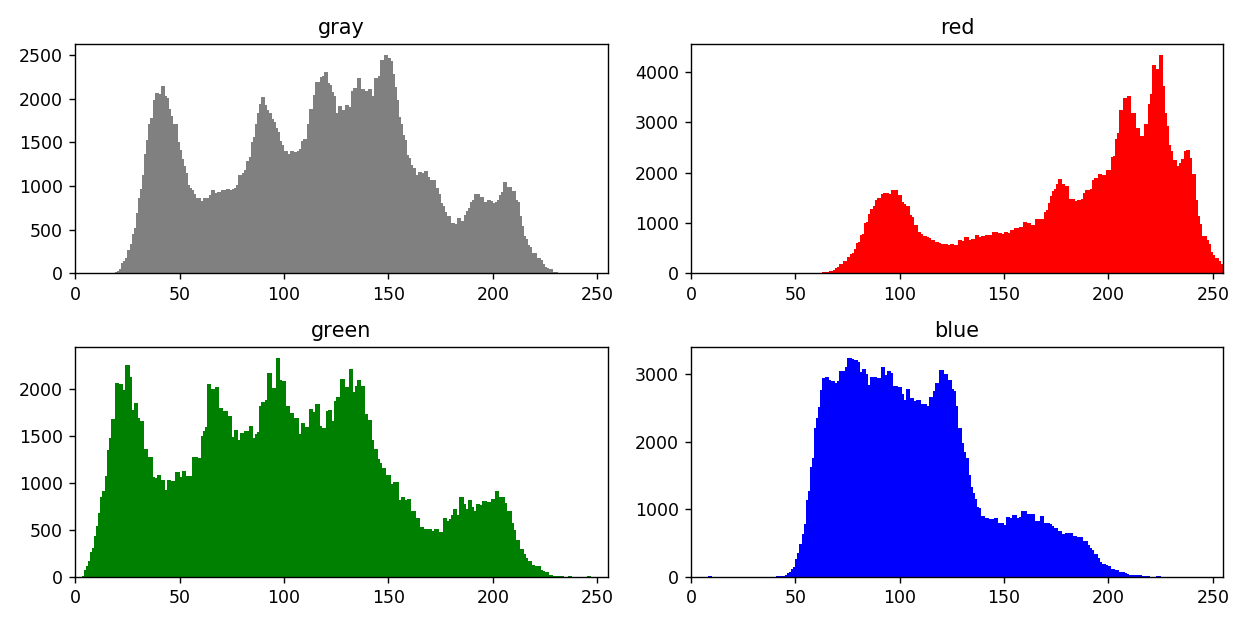

In [6]:
fig = plt.figure(figsize=(10,5))

colors = ['gray','red', 'green', 'blue']
for i in range(0, 4):
    plt.subplot(2,2, i + 1)
    plt.title(colors[i])
    plt.bar(range(0, 256), hist[i,:], align='edge', width=2, color=colors[i])
    plt.xlim([0,255])
        
plt.tight_layout()
plt.show()

#plt.savefig('resources/histogram_gt.png')

### Cumulative histogram

Write a function to calculate the cumulative histogram for the grayscaled version of Lena. 

#### Solution

In [7]:
def cumulative(lena, hist):
    cumulative_hist = np.zeros(hist.shape, dtype=np.uint64)
    for b, v in enumerate(hist):   
        if b == 0:
            cumulative_hist[b] = hist[b]
        else:
            cumulative_hist[b] = cumulative_hist[b - 1] + hist[b]
        #cumulative_hist[b] = cumulative_hist[b - 1] + hist[b] if b != 0 else 0
    return cumulative_hist

cumulative_hist = cumulative(lena_rgb, hist[0])

#### Visualization

<IPython.core.display.Javascript object>


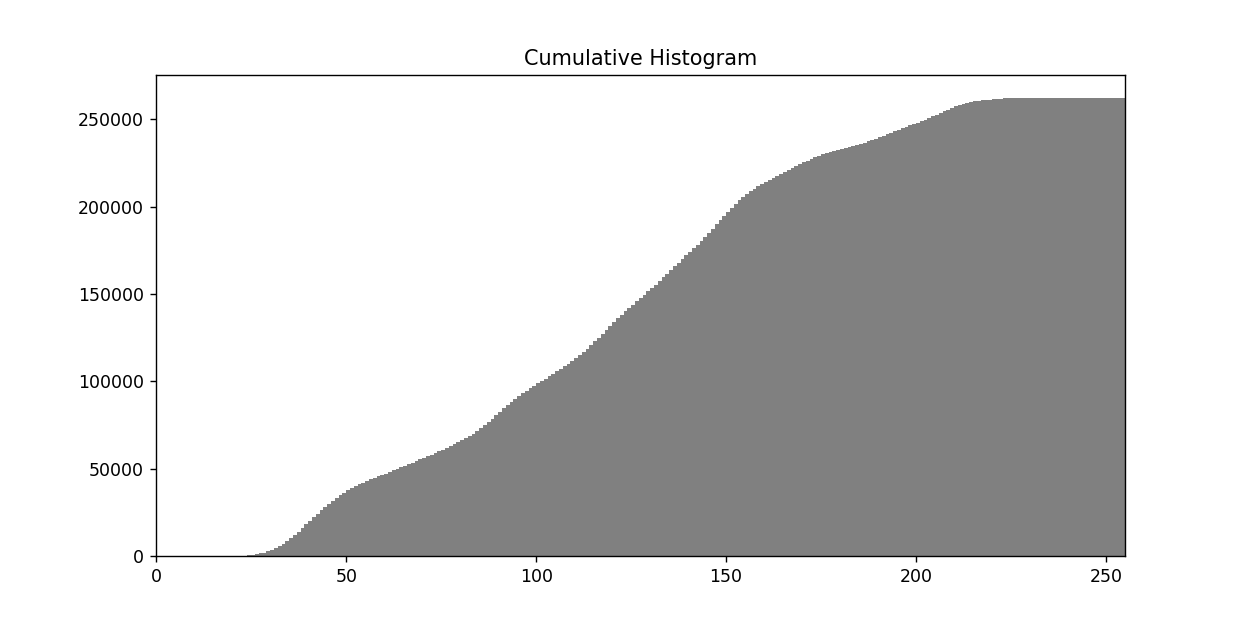

In [8]:
fig = plt.figure(figsize=(10,5))

plt.title('Cumulative Histogram')
plt.bar(range(0, 256), cumulative_hist, align='edge', width=2, color='gray')
plt.xlim([0,255])   

plt.show()

### calculate the mean, variance and standard deviation
Use the previously created grayscale histogram to calculate the mean value, variance and standard deviation

#### Solution

In [48]:
scale = 1.0 / (lena_rgb.shape[0] * lena_rgb.shape[1])
i = range(0, 256)
mean = (i * hist[0]).sum() * scale 
var = (((i - mean)**2) * hist[0]).sum() * scale
std = np.sqrt(var)
                                   
'Mean: {:.2f}, Var: {:.2f}, Std: {:.2f}'.format(mean, var, std) #.2f means up to 2 decimel values

'Mean: 116.27, Var: 2442.55, Std: 49.42'

In [49]:
'Numpy - Mean: {:.2f}, Var: {:.2f}, Std: {:.2f}'.format(gray.mean(), gray.var(), gray.std())

'Numpy - Mean: 116.27, Var: 2442.55, Std: 49.42'

## Point Operations

### Manual Contrast Adjustment

For the following exerciese you have to implement a manual contrast adjustment based on this formular: $f(m,n) = a[I(m,n) - s] + s $  where $a \in \mathbb{R}, s \in [0, 255]$.
Additional you implement the same approach with a Lookup-Table (LUT). Can you see the benefits of a LUT? At least you can visualize the values of the LUT using `plt.plot` and the histogram.

**Visualization proposal**:
![](resources/manual_contrast_adjustment.png)

**Hint**
* You don't need to loop over the x and y coordinates of your image because only the luminance values are important not the coordinates. Check the function `numpy.flatten`
* You can measure the execution time in Python like this:
```python
    start = time.time()    
    # code block start
    
    # code block end
    diff = time.time() - start # execution time in seconds
    print("Loop execution time: {:.3f} ms".format(diff * 1000))
```

#### Solution

In [55]:
lena_low_contrast = np.array(Image.open('D:/MS_TUC/My files/CV-1/Ubung_main/Exercise-01/resources/lena-low-contrast.png'), dtype=np.uint8)

In [56]:
#@jit
def saturation(a, s):
    line = np.arange(0, 256, 1)
    flat = lena_low_contrast.flatten()

    img = flat.copy()    
    lut_gray = flat.copy()
    
    hist = np.zeros((256,), dtype=np.uint64)
    start = time.time()
    for idx, intensity in enumerate(flat):     #enumarate fn gets a list of tuples >> (index, intensity level) 
        img[idx] = max(0, min(255, a * (intensity - s) + s))
        hist[int(img[idx])] += 1
    
    loop_msg = 'Loop execution time: {:.3f} ms'.format((time.time() - start) * 1000)
    
    
    start = time.time()
    LUT = a * (line - s) + s
    lut_gray = lut_gray.flatten()
    for idx, intensity in enumerate(lut_gray):           
        lut_gray[idx] = LUT[int(intensity)]
        
    print(lut_gray.dtype)
    lut_msg = 'LUT execution time: {:.3f} ms'.format((time.time() - start) * 1000)
        
    plt.figure(figsize=(13,6))
    plt.subplot(2,3,1)   
    plt.title("original")
    plt.imshow(lena_low_contrast, cmap="gray", vmin=0, vmax=255)    
    plt.axis('off')
    plt.subplot(2,3,2)        
    plt.title(loop_msg)
    plt.imshow(img.reshape(lena_low_contrast.shape), cmap="gray", vmin=0, vmax=255)    
    plt.axis('off')
    plt.subplot(2,3,3)    
    plt.title(lut_msg)
    plt.imshow(lut_gray.reshape(lena_low_contrast.shape), cmap="gray", vmin=0, vmax=255)     
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.title('LUT')
    plt.plot(LUT)    
    plt.plot(s,s, 'rx') #rx marks a red cross at the middle of the function
    plt.xlabel('input intensity')
    plt.ylabel('output intensity')
    plt.ylim([0, 255])
    plt.subplot(2,2,4)
    plt.xlim([0, 255])    
    plt.title("Histogram")
    plt.bar(range(0, 256), hist, align='edge', width=2, color='gray')
    plt.xlim([0,255])
    plt.show()    
    plt.tight_layout()
    #plt.savefig('resources/manual_contrast_adjustment.png')

#### Visualization

In [57]:


@interact(
    a=FloatSlider(min=-1.0, max=10.0, value=1.0, step=0.05, continuous_update=False),
    s=FloatSlider(min=0.0, max=255.0, value=127.0, step=0.05, continuous_update=False)
)
def run(a, s):
    saturation(a, s)
    

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='a', max=10.0, min=-1.0, ste…

### Auto Contrast Adjustment

Manual adjustments are nice and give you the opportunity to adjust an image as you want. But if time is rare and you have a lot of images with low contrast, automation is the key. 
In this task you implement your own auto contrast operation on a low contrast version of lena (already grayscaled) and after this you calculate the histogram. For your auto contrast implementation use the formula below:

$f_{ac}(i) = (i - i_{low}) \frac{i_{max} - i_{min}}{i_{high} - i_{low}}$

**Visualization proposal:**
![](resources/auto_contrast_adjustment.png)


**Hint:** 
- you need your histogram (again)
- $i_{low}$ is the first non zero bin of the histogram while $i_{high}$ the last bin is
- $i_{max}$ is the maximum intensity for a pixel and $i_{low}$ the opposite

In [58]:
hist = np.zeros(256,dtype=np.uint8)
for intensity in lena_low_contrast.flatten():
    hist[intensity] += 1

<IPython.core.display.Javascript object>


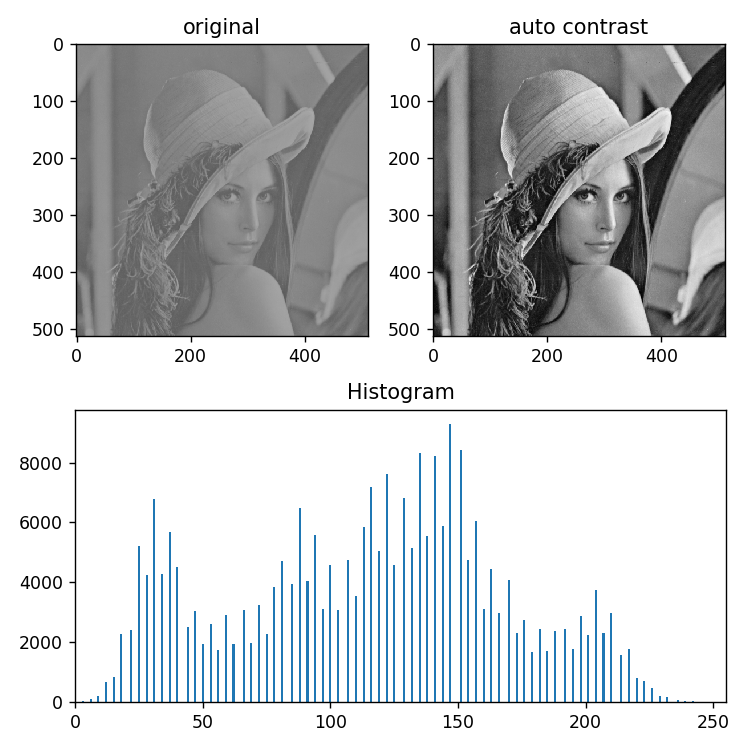

In [59]:
def autocontrast():    
    non_zero = []
    for bin_value, value in enumerate(hist):
        if value != 0:
            non_zero += [bin_value]        
    
    # or just np.nonzero(hist[0])
    
    low = non_zero[0]
    high = non_zero[-1]
    
    auto_contrast = (lena_low_contrast - low) * (255.0 / (high - low))
                

    plt.figure(figsize=(6,6))
    plt.subplot(2,2,1)    
    plt.title("original")
    plt.imshow(lena_low_contrast, cmap="gray", vmin=0, vmax=255)    
    plt.subplot(2,2,2)    
    plt.title("auto contrast")
    plt.imshow(auto_contrast, cmap="gray", vmin=0, vmax=255)        
    plt.subplot(2,1,2)    
    plt.title("Histogram")
    hist_auto = np.zeros(256, dtype=np.int64)
    for idx, value in enumerate(auto_contrast.flatten().astype(np.uint8)):         
        hist_auto[value] += 1
        
    plt.bar(range(0, 256), hist_auto)        
    plt.xlim([0, 255])
    plt.tight_layout()
    plt.savefig('resources/auto_contrast_adjustment.png')
autocontrast()

### Color Space Conversion - (optional)
A color space conversion is also a point operation. In this task you can try to implement the conversion from RGB -> HSL -> RGB. Compared to RGB where each plane represents a color and the final color the result of an addition of the R G B components is, HSL contains a hue, saturation and luminance component. The RGB color space can depicted as a cube where each component represents a axis while HSV can be represented as a cylinder. H is the angle for the color [0, 360°) on this cylinder, S is the saturation of the color [0, 1] and V the lightness [0, 1]

https://en.wikipedia.org/wiki/HSL_and_HSV

- RGB to HSV: https://en.wikipedia.org/wiki/HSL_and_HSV#From_RGB
- HSV to RGB: https://en.wikipedia.org/wiki/HSL_and_HSV#HSV_to_RGB


I highly recommend the Software "Fiji -  [Download](https://fiji.sc/)" and the *Color Inspector 3D* plugin (already included) to visualize the color spaces

In [60]:
lena_rgb = np.array(Image.open('D:/MS_TUC/My files/CV-1/Ubung_main/Exercise-01/resources/Lena.png'), dtype=np.uint8)
flat = lena_rgb.reshape([-1,3]) / 255.0

In [62]:
#@jit
def convert(flat, h, s, v):
    lena_new = np.zeros(flat.shape, dtype=np.uint8)
    for idx, (r,g,b) in enumerate(flat):
        H,S,V = 0, 0, 0
        Cmax = max(max(r,g),b)
        Cmin = min(min(r,g),b)
        delta = Cmax - Cmin
        
        if Cmax == r:
            H = 60 * ((g-b) / delta)
        elif Cmax == g:
            H = 60 * (2 + (b-r) / delta)
        elif Cmax == b:
            H = 60 * (4 + (r - g) / delta)
        
        S = delta / Cmax if Cmax != 0 else 0
        V = Cmax
        
        H += h
        S += s
        V += v

        S = np.clip(S, 0, 1)
        V = np.clip(V, 0, 1)
        
        if H < 0.0:
            H += 360
        
        C = V * S
        X = C * ( 1 - abs((H / 60) % 2 - 1 ))
        m = V - C
        
        if 0 <= H < 60:
            Rs, Gs, Bs = C, X, 0
        if 60 <= H < 120:
            Rs, Gs, Bs = X, C, 0
        if 120 <= H < 180:
            Rs, Gs, Bs = 0, C, X
        if 180 <= H < 240:
            Rs, Gs, Bs = 0, X, C
        if 240 <= H < 300:
            Rs, Gs, Bs = X, 0, C
        if 300 <= H < 360:
            Rs, Gs, Bs = C, 0, X
        
        lena_new[idx,]  = (Rs + m) * 255.0, (Gs + m) * 255.0, (Bs + m) * 255.0
        
    return lena_new

In [63]:
#@interact(h=(0, 360, 1), s = (-1.0, 1.0, 0.01), v =(-1.0, 1.0, 0.01))
@interact(h=FloatSlider(min=0, max=360, step=10, continuous_update=False),
          s=FloatSlider(min=-1, max=1, step=0.1, continuous_update=False), 
          v=FloatSlider(min=-1, max=1, step=0.1, continuous_update=False)
         )
def change_color(h=0, s=0, v=0):    
    lena_new = convert(flat, h, s, v)
    plt.figure(figsize=(10,10))
    plt.imshow(lena_new.reshape(lena_rgb.shape))
    plt.show()
    

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='h', max=360.0, step=10.0), …